In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [3]:
batch_size = 32
num_epochs = 10
learning_rate = 0.001

In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [5]:
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 26421880/26421880 [00:10<00:00, 2636714.48it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 208483.65it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3907205.26it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5047283.07it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [6]:
pretrained_model = models.resnet34(pretrained=True)
pretrained_model.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
num_features = pretrained_model.fc.in_features
pretrained_model.fc = nn.Linear(num_features, 10)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 156MB/s]


In [7]:
untrained_model = models.resnet34(pretrained=False)
untrained_model.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
untrained_model.fc = nn.Linear(num_features, 10)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pretrained_model = pretrained_model.to(device)
untrained_model = untrained_model.to(device)

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer_pretrained = optim.Adam(pretrained_model.parameters(), lr=learning_rate)
optimizer_untrained = optim.Adam(untrained_model.parameters(), lr=learning_rate)

In [10]:
def train(model, optimizer, train_loader):
    model.train()
    train_losses = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}')
    return train_losses

In [11]:
def test(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

In [12]:
print("Training pretrained model...")
pretrained_losses = train(pretrained_model, optimizer_pretrained, train_loader)
pretrained_accuracy = test(pretrained_model, test_loader)
print(f'Accuracy of pretrained model: {pretrained_accuracy:.2f}%')

print("Training untrained model...")
untrained_losses = train(untrained_model, optimizer_untrained, train_loader)
untrained_accuracy = test(untrained_model, test_loader)
print(f'Accuracy of untrained model: {untrained_accuracy:.2f}%')

Training pretrained model...
Epoch [1/10], Loss: 0.3626
Epoch [2/10], Loss: 0.2391
Epoch [3/10], Loss: 0.1989
Epoch [4/10], Loss: 0.1692
Epoch [5/10], Loss: 0.1421
Epoch [6/10], Loss: 0.1177
Epoch [7/10], Loss: 0.0899
Epoch [8/10], Loss: 0.0689
Epoch [9/10], Loss: 0.0528
Epoch [10/10], Loss: 0.0390
Accuracy of pretrained model: 94.04%
Training untrained model...
Epoch [1/10], Loss: 0.4626
Epoch [2/10], Loss: 0.2893
Epoch [3/10], Loss: 0.2419
Epoch [4/10], Loss: 0.2105
Epoch [5/10], Loss: 0.1827
Epoch [6/10], Loss: 0.1567
Epoch [7/10], Loss: 0.1340
Epoch [8/10], Loss: 0.1118
Epoch [9/10], Loss: 0.0883
Epoch [10/10], Loss: 0.0676
Accuracy of untrained model: 93.52%


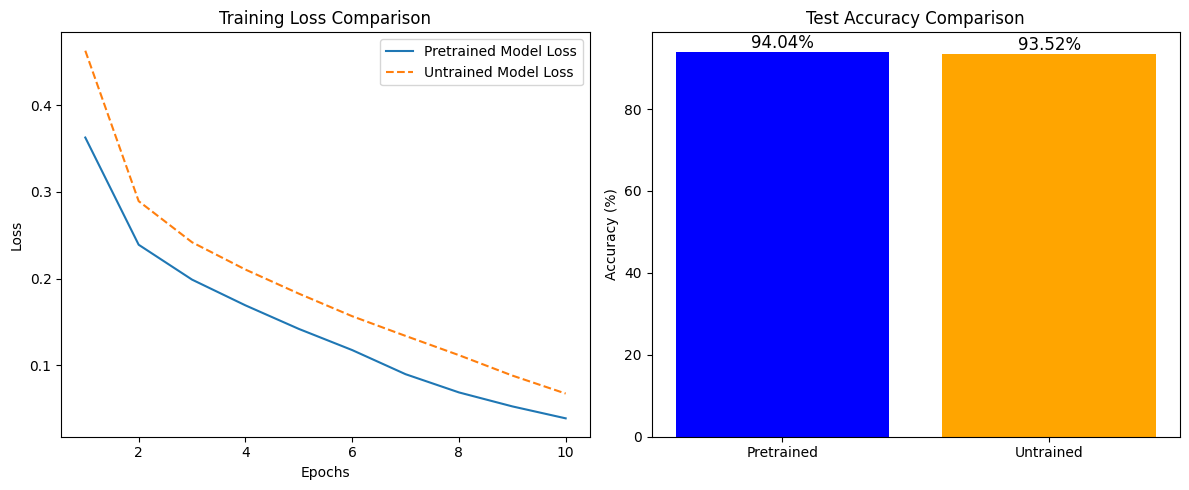

In [19]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, pretrained_losses, label='Pretrained Model Loss')
plt.plot(epochs, untrained_losses, label='Untrained Model Loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Comparison')
plt.legend()

plt.subplot(1, 2, 2)
bars = plt.bar(['Pretrained', 'Untrained'], [pretrained_accuracy, untrained_accuracy], color=['blue', 'orange'])
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Comparison')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}%', ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()
